# ENSF 645 - Assignment 2: Garbage Classification Model - Programming Assignment

# Summary:
The City of Calgary aims to develop a system that classifies waste into four categories—green, blue, black, and other (take to recycling, TTR) — using both images and short text descriptions. The project involves gathering a dataset of images and descriptions (which has been pre-split into training, validation, and test sets), training a machine learning model with Python, and evaluating its performance based on test accuracy.

# Completed By:

Aidan MacNichol – 30094369

Bailey Collison – 30133909

David Pozniak – 00324580

Yael Gonzalez - 30247278

## Environment Setup and Imports

This block sets up the environment and imports necessary libraries for model training and evaluation.
Not all of them were used, but including them is convienient for testing


In [ ]:
import torch
torch.cuda.empty_cache()
import torchvision
from torchvision import datasets as ds, transforms, models 
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet18, mobilenet_v2, MobileNet_V2_Weights
from transformers import DistilBertModel, DistilBertTokenizer, AdamW, AutoProcessor, get_scheduler, AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader, Dataset 

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageOps, Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
  print(f'Device {i} name:', torch.cuda.get_device_name(i))

# Here are a bunch of model parameters for easy altering.
batch_size = 32
image_resize = 224
num_workers = 8
num_epochs = 20
max_len = 24
learning_rate = 2e-5
showFirstTenMissClassed = 20
stats = (torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]))

2025-02-26 22:16:52.012984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740633412.028050    4214 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740633412.033553    4214 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 22:16:52.054179: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Device 0 name: NVIDIA GeForce RTX 2080 Ti


## Data Processing and Multi-Modal Dataset

This section defines helper functions for processing images and text, and a class for handling multi-modal data. The `imshow` function displays images after reversing normalization. The `read_text_files_with_labels` function extracts text from file names and assigns labels based on directory structure. The `MultiModalDataset` class loads images and tokenize text using a transformer model, returning both as tensors for model training.


In [ ]:
# Modify the imshow function to ensure stats are on the same device as the image
def imshow(img, stats):
    mean = stats[0].view(3, 1, 1).to(img.device)
    std = stats[1].view(3, 1, 1).to(img.device)
    img = img * std + mean
    npimg = img.cpu().numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    # Get the class folder names and create a mapping from class name
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}
    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        # Process the directories that are class labels
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                # Make sure the file exists
                if os.path.isfile(file_path):
                    #Format the file name
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])
    return np.array(texts), np.array(labels)

# This is a modified version of the customdataset class. It was modified to include image data as well as prepare the text data via tokenization for the DistilBertModel.
class MultiModalDataset(Dataset):
    def __init__(self, image_dataset, texts, labels, tokenizer, max_len):
        self.image_dataset = image_dataset
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.image_dataset)
    def __getitem__(self, idx):
        # Get the image and label from the dataset
        image, label = self.image_dataset[idx]
        label = self.labels[idx]
        text = str(self.texts[idx])
        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        # Return a dictionary
        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## Training and Evaluation

This section defines functions for training, evaluating, and making predictions with the model. The `train` function optimizes the model. `evaluate` calculates validation loss and accuracy. The `predict` function generates predictions for new data, and `predictALL` evaluates accuracy per class and displas the misclassified images. The `epochLoop` function controls the training process with multiple epochs, it also has early stopping criteria to prevent overfitting by monitoring validation loss and accuracy changes. The model is saved when validation loss improves or accuracy increases to capture the best-performing version.


In [ ]:
# Define training function
def train(model, dataloader, optimizer, criterion, device):
    model.train() # Set the model to training mode
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        # Forward pass
        output = model(images, input_ids, attention_mask)
        loss = criterion(output, labels)
        # Compute gradiants and update model weight
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)
    
# Define evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval() # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            output = model(images, input_ids, attention_mask)
            loss = criterion(output, labels)
            total_loss += loss.item()
            # Get the predicted class with highest probability
            _, preds = torch.max(output, 1)
            total_correct += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
    # Comput accuracy
    accuracy = 100*total_correct / total_samples
    return total_loss / len(dataloader), accuracy

# Function to make predictions on new data
def predict(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient tracking
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

# Function to display accuracy per class and display misclassified images
def predictALL(model, dataloader, device, class_names, showFirstTenMissClassed):
    correct_pred = {classname: 0 for classname in class_names}
    total_pred = {classname: 0 for classname in class_names}
    model.eval()
    showFirstTenMissClassed = showFirstTenMissClassed
    black_acc = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            for label, prediction, image in zip(labels, preds, images):
                if label == prediction:
                    correct_pred[class_names[label]] += 1
                if label != prediction:
                    if showFirstTenMissClassed >= 0:
                        print(f"This is classed as: {class_names[label]}\nThe model predicted class: {class_names[prediction]}")
                        # Display the misclassified image
                        imshow(image, stats)
                        print(f"\n")
                        showFirstTenMissClassed -= 1
                total_pred[class_names[label]] += 1
    accuracy = 100-(100*(sum(total_pred.values())-sum(correct_pred.values()))/sum(total_pred.values()))
    print(f'Accuracy for all classes: {accuracy:.2f}%')
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.2f}%, class size: {total_pred[classname]:.0f}')
    return accuracy


# This is the epochLoop that loops over the training loop and the validation loop. 
# A few things are uninqe about it that one should take note: The stopping criteria - if the validation loss 
# increase by 50% over its lowest value, it typically (not always) means the model has started to over-fit so it breaks.
# For the same reason, if validation accuracy drops by 4%, the epoch loop stops. 
# These two break criteria prevent wasted time looping epochs while the model becomes worse and were tuned over time.
# Second, the model is saved via two criteria, instead of just minimizing validation loss, if the validation accuracy 
# increasses, the model also saves, this is an attempt to try to capture the best test accuracy possible.
# It was tested by calculating test accuracy as part of the loop to see each test accuracy per epoch, and found that in 
# saving the model in this way reduced passed up a better test accuracy, then to previent data leakage, test accuracy was removed.
def epochLoop(model, dataloaders, optimizer, criterion, device, class_names, num_epochs):
    best_loss = float('inf')
    best_val_accuracy = 0
    for epoch in range(num_epochs):
        print(f"\nStarted Training Loop =", datetime.now().strftime(f"%H:%M:%S"))
        train_loss = train(model, dataloaders['train'], optimizer, criterion, device)
        print(f"Started Validaiton Loop =", datetime.now().strftime(f"%H:%M:%S"))
        val_loss, val_accuracy = evaluate(model, dataloaders['val'], criterion, device)
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n')
        if val_loss >= best_loss*1.5 or val_accuracy <= best_val_accuracy*0.96:
            print(f"Validation error grew by 50%, or validation accuracy dropped by 4%, so stopped training.")
            break
        if val_loss <= best_loss or best_val_accuracy <= val_accuracy:
            torch.save(model.state_dict(), f'best_model.pth')
            print(f"The model has been saved!")
            if val_loss <= best_loss:
                best_loss = val_loss
                print(f"Due to lowest validation loss.")
            if best_val_accuracy <= val_accuracy:
                best_val_accuracy = val_accuracy
                print(f"Due to highest validation accuracy.")
        scheduler.step()

## Multi-Modal Classification Model

This section defines a model that processes both image and text inputs. The `MultiInputModel` uses a pre-trained MobileNetV2 for extracting image features and DistilBERT for processing text data. The model applies dropout and batch normalization to improve generalization.

Note:

Drop out helped here, but only with a lower value of 0.1, rather then 0.3. Activation functions applied to the final fully connected layer on each individual model tended to reduce test accuracy. Although applying activation functions to each layer of the combined models helped significantly. The single batch normalization after the first fullyed connected later of the combined models helped stabailize the loss functions so they treneded down more consistiently. Its placement was chosen as pretty much everywhere else it was included resulted in a (much) lower test accuracy. This includes to each model individually before combining them.

We experimented with more simple and more complex models, more convolutional layers, more fully connected layers... This ultimately just complicated things, increased run time, and did not improve results. A more simple model where the output of each individual model was 4, combined to 8 and reduced to 4 classifications again, performed nearly as well as the model we chose to go with. We landed on this model because it performed more consistently and more stable across multiple systems/runs. 

In [ ]:
class MultiInputModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiInputModel, self).__init__()
        # Image model
        self.image_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        num_features = self.image_model.classifier[1].in_features
        self.image_model.classifier[1] = nn.Identity()
        # Adding additional convolutional and pooling layers to image model
        self.conv1 = nn.Conv2d(in_channels=num_features, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Text model
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 768)
        # Combining both image and text features
        self.fc1 = nn.Linear(1280, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 16)
        self.fc4 = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.1)
        self.batch_norm1 = nn.BatchNorm1d(512)
        # Set requires_grad = True for all parameters in MobileNetV2 and DistilBERT to fine-tune them
        for param in self.image_model.parameters():
            param.requires_grad = True
        for param in self.text_model.parameters():
            param.requires_grad = True
    def forward(self, image, input_ids, attention_mask):
        # Image features
        image_features = self.image_model.features(image)
        image_features = self.pool1(F.relu(self.conv1(image_features)))
        image_features = self.pool2(F.relu(self.conv2(image_features)))
        image_features = image_features.mean([2, 3])  # Global Average Pooling
        # Text features
        text_features = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[0]
        text_features = text_features[:, 0, :]  # Use [CLS] token for classification
        text_features = self.text_fc(text_features)
        # Combine image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)
        # Classifier with Activation functions, and Dropout
        combined_features = self.fc1(combined_features)
        combined_features = F.relu(combined_features)
        combined_features = self.dropout(combined_features)
        combined_features = self.batch_norm1(combined_features)
        combined_features = self.fc2(combined_features)
        combined_features = F.relu(combined_features)
        combined_features = self.dropout(combined_features)
        combined_features = self.fc3(combined_features)
        combined_features = F.relu(combined_features)
        combined_features = self.dropout(combined_features)
        combined_features = self.fc4(combined_features)
        return combined_features

## Dataset Preparation and Data Loaders

This section sets up the image transformations, loads datasets, and prepares data loaders for training, validation, and testing. The `transform` dictionary defines preprocessing steps. The dataset paths are specified, and both image and text data are extracted. The `MultiModalDataset` class is used to combine image and text inputs for multi-modal learning. `DataLoader` objects are created for optimized training performance.

In [5]:
transform = {
    "train": transforms.Compose([
        transforms.Resize((232, 232), interpolation=InterpolationMode.BILINEAR),
        transforms.RandomCrop(image_resize),
        transforms.Resize((image_resize, image_resize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Location of the datasets
data_dir = r"/home/poz/garbage_data"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

# Extract text + lables
text_train, labels_train = read_text_files_with_labels(train_dir)
text_val, labels_val = read_text_files_with_labels(val_dir)
text_test, labels_test = read_text_files_with_labels(test_dir)

# Extract images
datasets = {"train": ds.ImageFolder(train_dir, transform=transform["train"]),
            "val": ds.ImageFolder(val_dir, transform=transform["val"]),
            "test": ds.ImageFolder(test_dir, transform=transform["test"])}

class_names = datasets['train'].classes
num_classes=len(class_names)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Combine the two datasets with the MultiModalDataset class
datasets = {"train": MultiModalDataset(datasets['train'], text_train, labels_train, tokenizer, max_len),
            "val": MultiModalDataset(datasets['val'], text_val, labels_val, tokenizer, max_len),
            "test": MultiModalDataset(datasets['test'], text_test, labels_test, tokenizer, max_len)}

dataloaders = {"train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
               "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
               "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)}

print(class_names)
print("Train set:", len(dataloaders['train'])*batch_size)
print("Val set:", len(dataloaders['val'])*batch_size)
print("Test set:", len(dataloaders['test'])*batch_size)

['Black', 'Blue', 'Green', 'TTR']
Train set: 11648
Val set: 1824
Test set: 3456


## Model Initialization and Training Setup

In [6]:
model = MultiInputModel(num_classes).to(device)

# Training parameters, adding a very small weight_decay to the optimizer 
# helped the model perform better, as did using a scheduler with a large step_size and gamma value of 1.
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-10)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=1)

## Run the Model

The run time is relatively quick, on a 2080 ti it takes about 70 seconds per loop, on a 4050 it takes about 2 minutes, and about 15 mintues per loop on the TALC cluster. The model has been balanced to run quickly while still maintaining a high test accuracy.

In [ ]:
epochLoop(model, dataloaders, optimizer, criterion, device, class_names, num_epochs)


Started Training Loop = 22:16:56


Training: 100%|██████████| 364/364 [01:06<00:00,  5.45it/s]


Started Validaiton Loop = 22:18:02


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.62it/s]



Epoch 1/20
Train Loss: 0.7569
Val Loss: 0.3762, Val Accuracy: 89.89%

The model has been saved!
Due to lowest validation loss.
Due to highest validation accuracy.

Started Training Loop = 22:18:10


Training: 100%|██████████| 364/364 [01:06<00:00,  5.47it/s]


Started Validaiton Loop = 22:19:17


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.47it/s]



Epoch 2/20
Train Loss: 0.3405
Val Loss: 0.2590, Val Accuracy: 92.39%

The model has been saved!
Due to lowest validation loss.
Due to highest validation accuracy.

Started Training Loop = 22:19:25


Training: 100%|██████████| 364/364 [01:05<00:00,  5.57it/s]


Started Validaiton Loop = 22:20:30


Validating: 100%|██████████| 57/57 [00:08<00:00,  6.66it/s]



Epoch 3/20
Train Loss: 0.2278
Val Loss: 0.2071, Val Accuracy: 93.50%

The model has been saved!
Due to lowest validation loss.
Due to highest validation accuracy.

Started Training Loop = 22:20:39


Training: 100%|██████████| 364/364 [01:05<00:00,  5.54it/s]


Started Validaiton Loop = 22:21:45


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.60it/s]



Epoch 4/20
Train Loss: 0.1611
Val Loss: 0.2021, Val Accuracy: 93.28%

The model has been saved!
Due to lowest validation loss.

Started Training Loop = 22:21:53


Training: 100%|██████████| 364/364 [01:06<00:00,  5.50it/s]


Started Validaiton Loop = 22:22:59


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.63it/s]



Epoch 5/20
Train Loss: 0.1314
Val Loss: 0.1969, Val Accuracy: 94.22%

The model has been saved!
Due to lowest validation loss.
Due to highest validation accuracy.

Started Training Loop = 22:23:07


Training: 100%|██████████| 364/364 [01:06<00:00,  5.50it/s]


Started Validaiton Loop = 22:24:14


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.45it/s]



Epoch 6/20
Train Loss: 0.1026
Val Loss: 0.2682, Val Accuracy: 92.83%


Started Training Loop = 22:24:21


Training: 100%|██████████| 364/364 [01:06<00:00,  5.51it/s]


Started Validaiton Loop = 22:25:27


Validating: 100%|██████████| 57/57 [00:08<00:00,  6.62it/s]



Epoch 7/20
Train Loss: 0.0872
Val Loss: 0.2201, Val Accuracy: 93.67%


Started Training Loop = 22:25:36


Training: 100%|██████████| 364/364 [01:06<00:00,  5.50it/s]


Started Validaiton Loop = 22:26:42


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.69it/s]



Epoch 8/20
Train Loss: 0.0682
Val Loss: 0.2648, Val Accuracy: 93.06%


Started Training Loop = 22:26:49


Training: 100%|██████████| 364/364 [01:07<00:00,  5.40it/s]


Started Validaiton Loop = 22:27:57


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.51it/s]



Epoch 9/20
Train Loss: 0.0603
Val Loss: 0.2325, Val Accuracy: 93.61%


Started Training Loop = 22:28:05


Training: 100%|██████████| 364/364 [01:09<00:00,  5.21it/s]


Started Validaiton Loop = 22:29:14


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.26it/s]



Epoch 10/20
Train Loss: 0.0534
Val Loss: 0.2647, Val Accuracy: 93.39%


Started Training Loop = 22:29:22


Training: 100%|██████████| 364/364 [01:09<00:00,  5.23it/s]


Started Validaiton Loop = 22:30:32


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.75it/s]



Epoch 11/20
Train Loss: 0.0501
Val Loss: 0.2684, Val Accuracy: 93.67%


Started Training Loop = 22:30:39


Training: 100%|██████████| 364/364 [01:09<00:00,  5.24it/s]


Started Validaiton Loop = 22:31:49


Validating: 100%|██████████| 57/57 [00:08<00:00,  7.02it/s]



Epoch 12/20
Train Loss: 0.0411
Val Loss: 0.2639, Val Accuracy: 93.67%


Started Training Loop = 22:31:57


Training: 100%|██████████| 364/364 [01:09<00:00,  5.23it/s]


Started Validaiton Loop = 22:33:06


Validating: 100%|██████████| 57/57 [00:08<00:00,  6.66it/s]



Epoch 13/20
Train Loss: 0.0344
Val Loss: 0.2787, Val Accuracy: 93.28%


Started Training Loop = 22:33:15


Training: 100%|██████████| 364/364 [01:08<00:00,  5.32it/s]


Started Validaiton Loop = 22:34:23


Validating: 100%|██████████| 57/57 [00:07<00:00,  7.41it/s]



Epoch 14/20
Train Loss: 0.0280
Val Loss: 0.2989, Val Accuracy: 93.11%

Validation error grew by 50%, or validation accuracy dropped by 4%, so stopped training.


The following cell computes the a break down of the test accuracy for the total test set and per classification.

Please note that the best score we had for image only classification was 64-65% and text only was 84-85%. We gained at least 4% by combining the two models. 

Here are the results:

Accuracy for all classes: 89.45%

Accuracy for class: Black is 83.74%, class size: 695

Accuracy for class: Blue  is 90.52%, class size: 1086

Accuracy for class: Green is 97.12%, class size: 799

Accuracy for class: TTR   is 85.56%, class size: 852

Included with the results are 20 images that were misclassifed to give an idea of why that might be. There are less then 500 images misclassified, if you wish to see more, you can alter showFirstTenMissClassed to 500 and run all the cells aside from the cell above this one (with epochLoop). Note that if you take a look you might see some incorrectly labled where the model got them correct (you will need to display more, the appear in order of the batches). We believe the misclassification of some of the images by students is the largest, or one of the largest, limiting factor of the model (with the datasets being unbalanced as another of the possible reducible errors)

Evaluating:   0%|          | 0/108 [00:00<?, ?it/s]

This is classed as: Black
The model predicted class: Blue


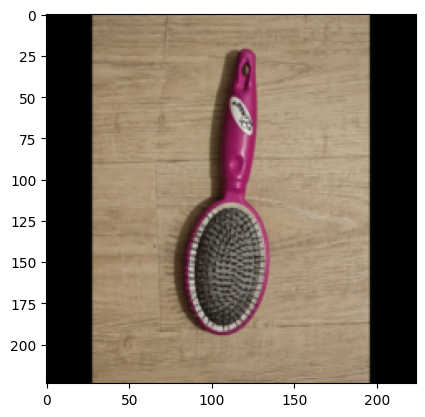



This is classed as: Black
The model predicted class: TTR


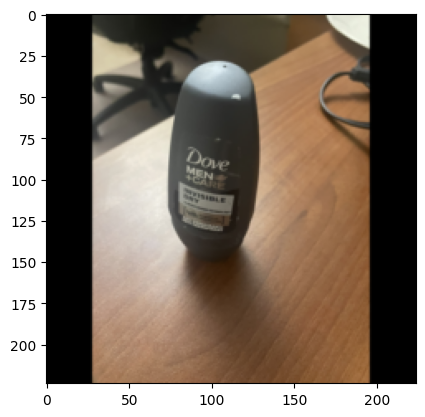



This is classed as: Black
The model predicted class: Green


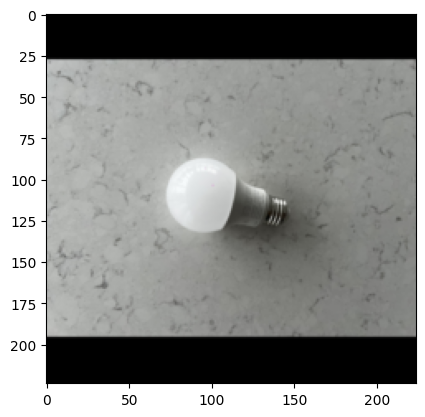



This is classed as: Black
The model predicted class: TTR


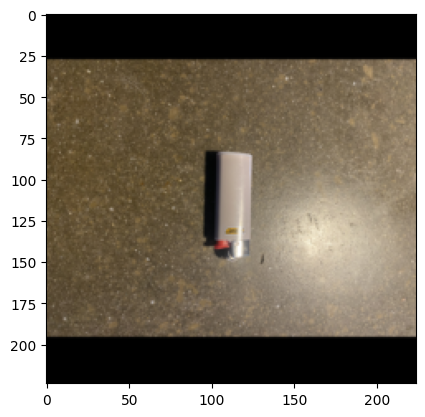



This is classed as: Black
The model predicted class: Blue


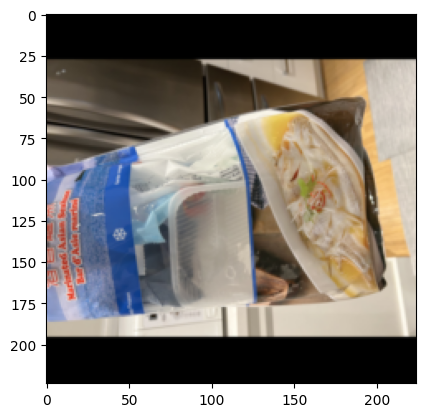

Evaluating:   1%|          | 1/108 [00:02<03:36,  2.02s/it]



This is classed as: Black
The model predicted class: Blue


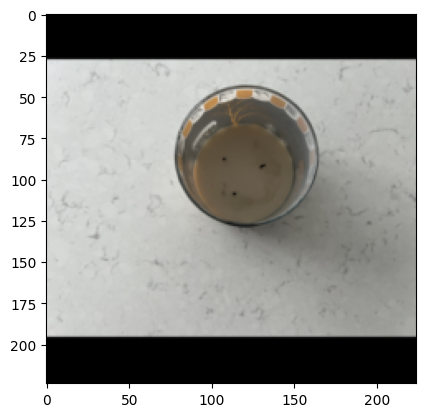



This is classed as: Black
The model predicted class: TTR


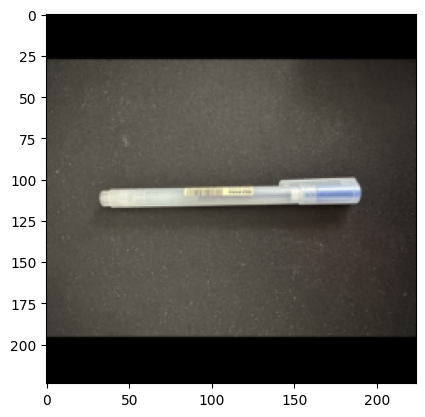



This is classed as: Black
The model predicted class: Blue


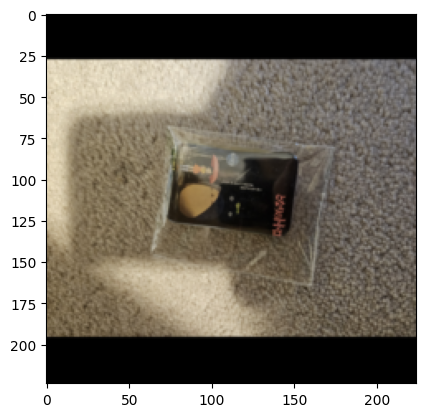



This is classed as: Black
The model predicted class: TTR


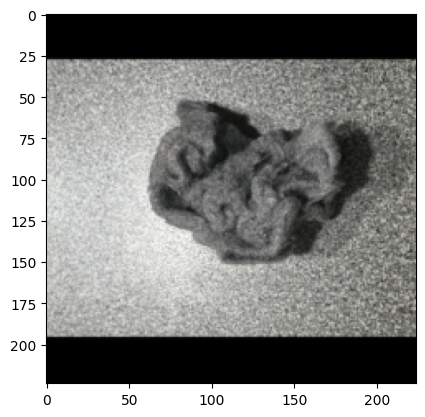



This is classed as: Black
The model predicted class: Blue


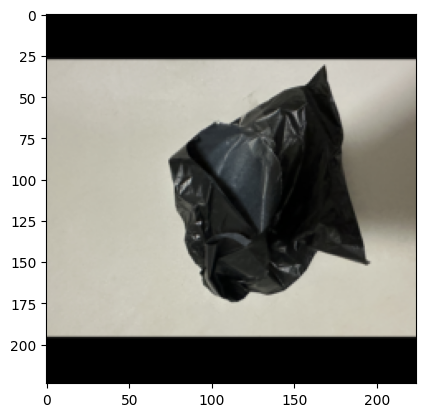



This is classed as: Black
The model predicted class: TTR


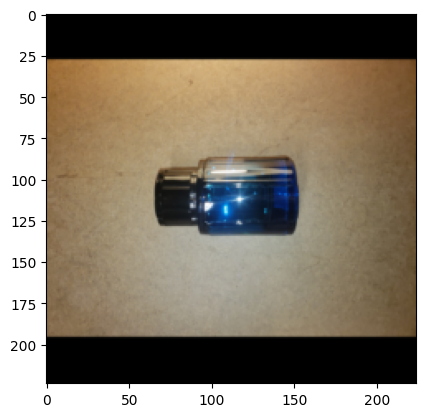

Evaluating:   2%|▏         | 2/108 [00:02<02:12,  1.25s/it]



This is classed as: Black
The model predicted class: TTR


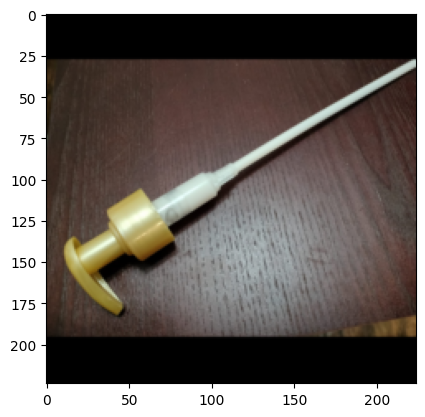



This is classed as: Black
The model predicted class: Blue


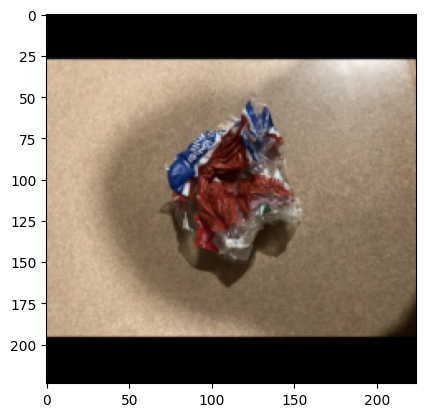



This is classed as: Black
The model predicted class: Blue


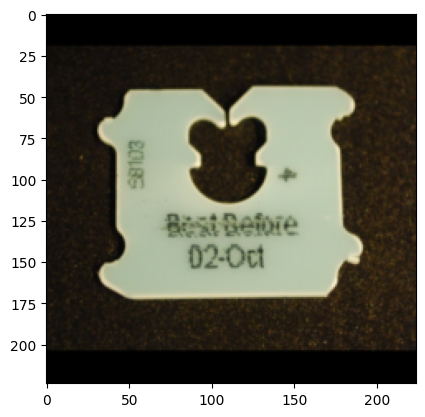



This is classed as: Black
The model predicted class: Blue


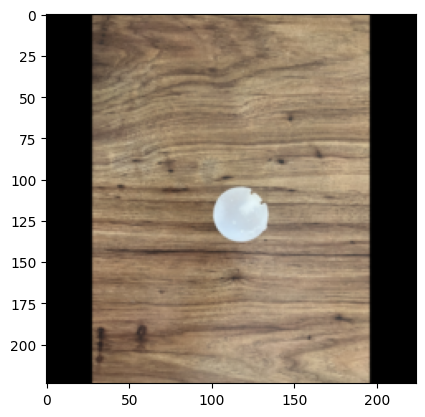



This is classed as: Black
The model predicted class: TTR


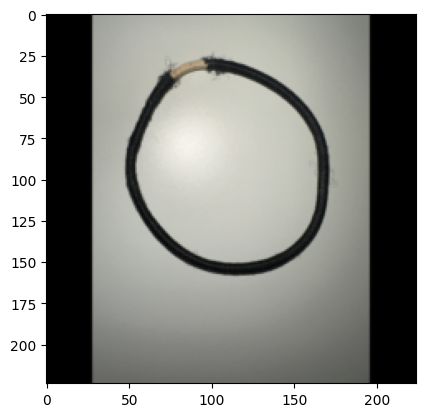



This is classed as: Black
The model predicted class: TTR


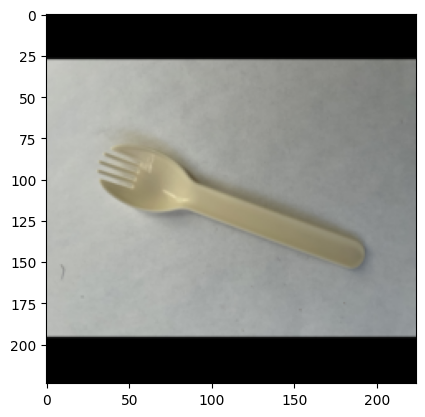



This is classed as: Black
The model predicted class: TTR


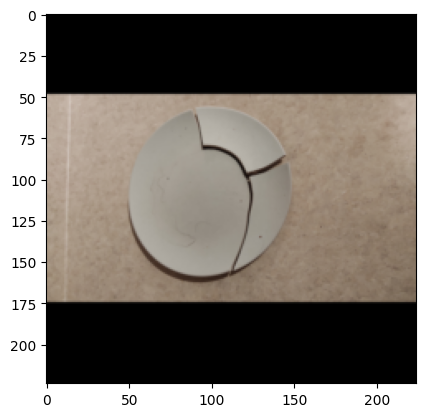



This is classed as: Black
The model predicted class: Blue


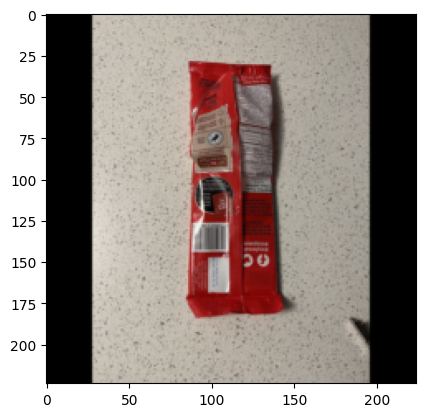



This is classed as: Black
The model predicted class: Blue


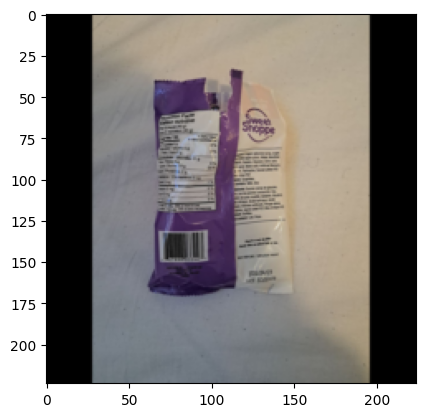

Evaluating:   3%|▎         | 3/108 [00:03<01:56,  1.11s/it]



This is classed as: Black
The model predicted class: TTR


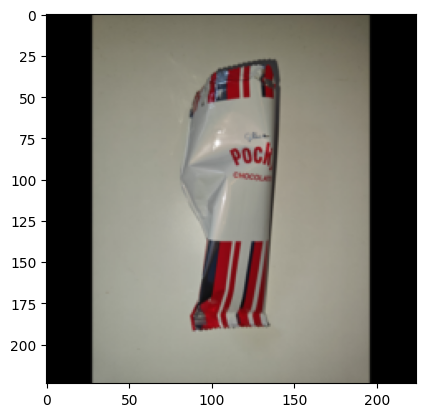

Evaluating:   4%|▎         | 4/108 [00:03<01:15,  1.38it/s]

Evaluating: 100%|██████████| 108/108 [00:16<00:00,  6.74it/s]

Accuracy for all classes: 89.45%
Accuracy for class: Black is 83.74%, class size: 695
Accuracy for class: Blue  is 90.52%, class size: 1086
Accuracy for class: Green is 97.12%, class size: 799
Accuracy for class: TTR   is 85.56%, class size: 852


In [10]:
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy = predictALL(model, dataloaders['test'], device, class_names, showFirstTenMissClassed)

One of the goals was to have a balanced dataset. One can see that this is not a balanced dataset. The test set is a bit more balanced but still more blue then any other, with less black.
However, the validation set is very unbalanced with nearly twice as many blue then black, green or TTR. 
It is because of this unbalance that we believe our criteria to save the model helps attain a better test accuracy. 
The unbalance seems to cause the validation loss, validation accuracy and test accuracy to be less correlated. A higher validation loss may still result in a higher validation and test accuracy. A higher validation accuracy does not mean a lower validation loss or higher test accuracy. Although, those relationship are generally true, not always between every epoch.

In [11]:
val_accuracy = predictALL(model, dataloaders['val'], device, class_names, -1)

Evaluating: 100%|██████████| 57/57 [00:08<00:00,  6.96it/s]

Accuracy for all classes: 94.22%
Accuracy for class: Black is 94.09%, class size: 372
Accuracy for class: Blue  is 93.10%, class size: 768
Accuracy for class: Green is 96.59%, class size: 352
Accuracy for class: TTR   is 94.48%, class size: 308


Below is a confusion matrix to provide a more detailed brake down of the misclassifications.

Evaluating: 100%|██████████| 108/108 [00:15<00:00,  7.13it/s]


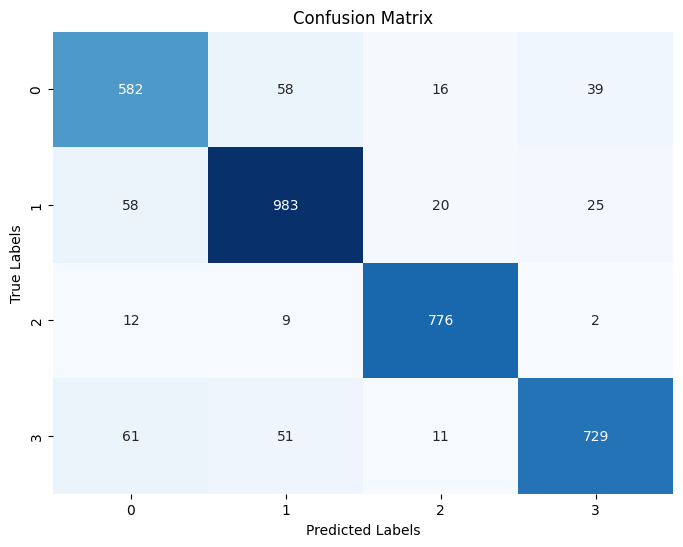

In [12]:
# Evaluation
test_predictions = np.array(predict(model, dataloaders['test'], device))

cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()